# Libraries

In [0]:
import numpy as np
import pandas as pd
import cv2
import glob
from google.colab.patches import cv2_imshow

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.tensorboard as tb

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

from torch import save
from torch import load
from os import path
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler

import cv2

# Video Generation Functions

In [0]:
# Colors (B, G, R)
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (0, 0, 255)
GREEN = (0, 255, 0)


def show_steering(image, truth_angle=-1, pred_angle=-1, amplifier=1):
    '''
    INPUTS:
      image - original unmodified image
      truth_angle - Ground Truth Angle in radians (-1: DO NOT DISPLAY). Positive CW, Negative CCW.
      pred_angle - Predcited Angle in radians (-1: DO NOT DISPLAY). Positive CW, Negative CCW.
    OUTPUTS:
      Initial image overlayed with graphics
    '''

    # Semi-Cirlce Border
    if (truth_angle != -1 or pred_angle != -1):

        # Semi-Circle
        height, width = image.shape[0:2]
        radius = 120
        width_center = int(width / 2)
        height_center = int(height-5)
        center = (width_center, height_center)
        axes = (radius, radius)
        angle = 0
        startAngle = 180
        endAngle = 360
        thickness = 2
        cv2.ellipse(image, center, axes, angle, startAngle, endAngle, BLUE, thickness)

        # 0 Tick-Mark
        start_point = (width_center, height_center-radius)
        end_point = (start_point[0], start_point[1] + 4)
        cv2.line(image, start_point, end_point, BLUE, thickness) 

        # -90 Tick-Mark
        start_point = (width_center + radius, height_center)
        end_point = (start_point[0] - 4, start_point[1])
        cv2.line(image, start_point, end_point, BLUE, thickness) 

        # +90 Tick-Mark
        start_point = (width_center - radius, height_center)
        end_point = (start_point[0] + 4, start_point[1])
        cv2.line(image, start_point, end_point, BLUE, thickness) 

        # -45 Tick-Mark
        start_x = int(width_center - radius * np.sin(-np.pi/4))
        start_y = int(height_center - radius * np.cos(-np.pi/4))
        start_point = (start_x, start_y)
        end_point = (start_point[0] - 3, start_point[1] + 3)
        cv2.line(image, start_point, end_point, BLUE, thickness) 

        # +45 Tick-Mark
        start_x = int(width_center - radius * np.sin(np.pi/4))
        start_y = int(height_center - radius * np.cos(np.pi/4))
        start_point = (start_x, start_y)
        end_point = (start_point[0] + 3, start_point[1] + 3)
        cv2.line(image, start_point, end_point, BLUE, thickness) 

    # Ground Truth Steering Angle
    if (truth_angle != -1):

        # experiment to make steering angle more noticeable
        truth_angle *= amplifier

        start_point = center
        end_x = int(width_center - (radius-5) * np.sin(truth_angle))
        end_y = int(height_center - (radius-5) * np.cos(truth_angle))
        end_point = (end_x, end_y)
        thickness = 2
        cv2.arrowedLine(image, start_point, end_point, GREEN, thickness, tipLength = 0.1)  
        
        # Overlay Text
        font = cv2.FONT_HERSHEY_SIMPLEX 
        org = (90, 450) 
        fontScale = 1
        color = (0, 255, 0)  #BGR
        thickness = 2
        image = cv2.putText(image, 'Truth', org, font,  
                           fontScale, color, thickness, cv2.LINE_AA) 

    # Prediction Steering Angle
    if (pred_angle != -1):

        # Experiment to make steering angle more noticeable
        pred_angle *= amplifier

        start_point = center
        end_x = int(width_center - (radius-5) * np.sin(pred_angle))
        end_y = int(height_center - (radius-5) * np.cos(pred_angle))
        end_point = (end_x, end_y)
        thickness = 2
        cv2.arrowedLine(image, start_point, end_point, RED, thickness, tipLength = 0.1)  
        
        # Overlay Text
        font = cv2.FONT_HERSHEY_SIMPLEX 
        org = (460, 450) 
        fontScale = 1
        color = (0, 0, 255)  #BGR
        thickness = 2
        image = cv2.putText(image, 'Predicted', org, font,  
                           fontScale, color, thickness, cv2.LINE_AA) 
    
    return image


def create_video(image_path, image_names, labels, preds, amplifier):
    '''
    INPUTS:
      images - list of filenames
      labels - Ground truth steering angles
      predictions - CNN predicted steering angles
      loss - RMSE loss for each image during validation
    '''

    # Video Setup
    out = cv2.VideoWriter('Test_Output_Video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (640, 480))
    num_files = len(image_names)

    # Loop through images
    for idx in range(num_files):
        
        # Data
        filename = str(image_names.iloc[idx, 0]) + '.jpg'
        label = labels.iloc[idx][0]
        pred = preds.iloc[idx][0]

        # Load Image
        img = cv2.imread(image_path + filename)

        # Modify and Write Image
        img = show_steering(img, label, pred, amplifier)
        out.write(img)

        # Print Progress Status
        if idx % 100 == 0:
            print('Video Creation Progress: ', int(100*idx/num_files), '%')

    out.release()


# Show_steering Debugging

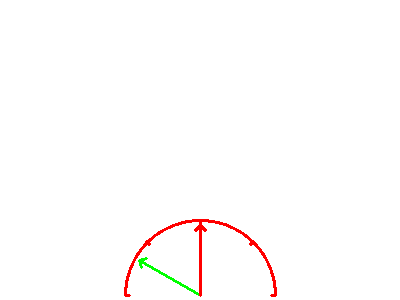

In [0]:
# DEBUGGING ONLY: Creates a dummy image with dummy angles to send to show_steering()
image = np.zeros((300, 400, 3), np.uint8)
image[:] = WHITE
show_steering(image, truth_angle=np.pi/6, pred_angle=0)
cv2_imshow(image)
#cv2.imwrite('DEBUGGING: Steering Display.jpg', image)

# Main

In [0]:

############### Change these based on image location:  ##########
# Paths
csv_path = '' # csv with image names, labels, & predictions
image_path = ''

# Data
data = pd.read_csv(csv_path)
image_names = pd.DataFrame(data[data.columns[0]])
labels = pd.DataFrame(data[data.columns[1]])
preds = pd.DataFrame(data[data.columns[2]])

# Multiplier with both true and predicted angles to make steering arrow changes more visible
amplifier = 1.5

# Call Video Creator & Image Modifier
create_video(image_path, image_names, labels, preds, amplifier)

/content/drive/My Drive/Colab Notebooks/CIS519 - Applied Machine Learning/Project
Video Creation Progress:  0 %
Video Creation Progress:  25 %
Video Creation Progress:  50 %
Video Creation Progress:  75 %
